# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [8]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

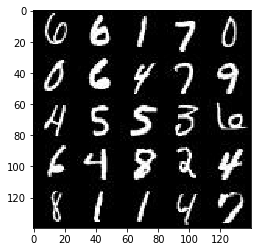

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

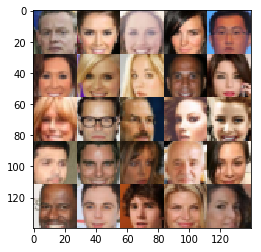

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs= tf.placeholder(tf.float32, (None,image_width, image_height, image_channels ), name= 'input_real')
    z_inputs= tf.placeholder(tf.float32, (None, z_dim), name= 'input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return real_inputs, z_inputs, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob= 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu_x1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu_x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu_x2 = tf.maximum(alpha*x2, x2)
        relu_x2 = tf.nn.dropout(relu_x2, keep_prob=keep_prob)

        # 7x7x128
        
        x3 = tf.layers.conv2d(relu_x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu_x3 = tf.maximum(alpha*x3, x3)
        relu_x3 = tf.nn.dropout(relu_x3, keep_prob=keep_prob)
        # 4x4x256
        
        flat = tf.reshape(relu_x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob= 0.9
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu_x1 = tf.maximum(alpha*x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(relu_x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu_x2 = tf.maximum(alpha*x2, x2)
        relu_x2 = tf.nn.dropout(relu_x2, keep_prob=keep_prob)

        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(relu_x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu_x3 = tf.maximum(alpha*x3, x3)
        relu_x3 = tf.nn.dropout(relu_x3, keep_prob=keep_prob)

        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(relu_x3, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
    return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_real,
            labels = tf.ones_like(d_model_real) * (1 - smooth)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
            labels = tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
            labels = tf.ones_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    samples = []
    losses=[]
    steps = 0
    print_every = 20
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                   # TODO: Train Model
                steps += 1
                batch_images *= 2 

                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

        saver.save(sess, './generator.ckpt')
    
    return losses
    
   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5050... Generator Loss: 3.7008
Epoch 1/2... Discriminator Loss: 1.9054... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 2.0385
Epoch 1/2... Discriminator Loss: 1.9025... Generator Loss: 3.1742
Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 0.4605


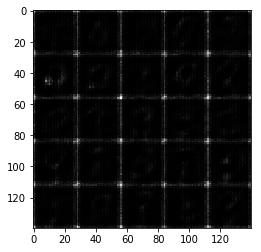

Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 1.6999
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.1233
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 2.2731
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 1.4562


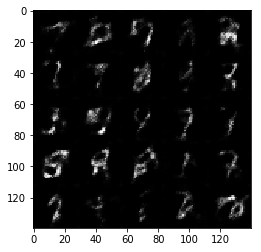

Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.5643... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 1.9413
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 2.0262
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 1.4065


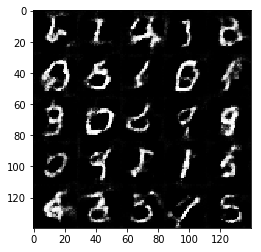

Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 1.0783
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.8440... Generator Loss: 3.0998
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 1.7558


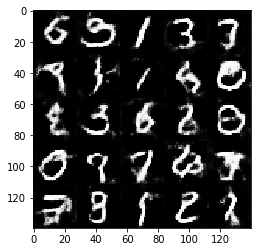

Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 1.6513... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 1.0978


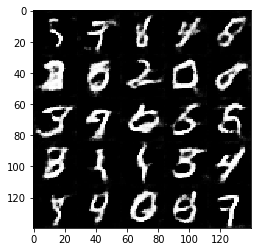

Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 1.5873... Generator Loss: 2.8673
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 1.3271


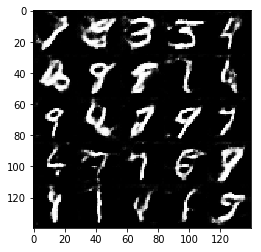

Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 1.1836
Epoch 1/2... Discriminator Loss: 1.0892... Generator Loss: 1.1858
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.5377
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.5422
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 0.9893


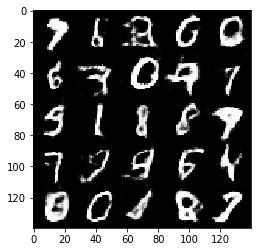

Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 1.4568
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.8081
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.9357


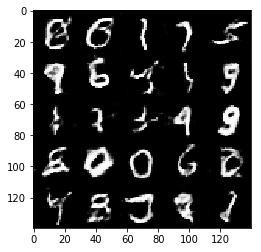

Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 2.0575
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.1995
Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 1.6213


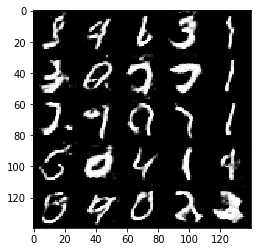

Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 1.3293
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.9453
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 1.8643


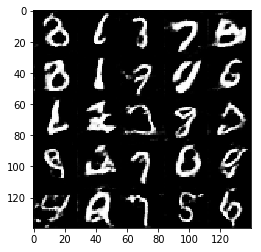

Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 1.5242
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.8248


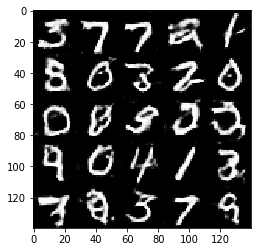

Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 1.2272
Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 1.4248
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 2.1934


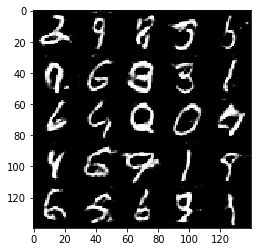

Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 2.1504
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 1.0450


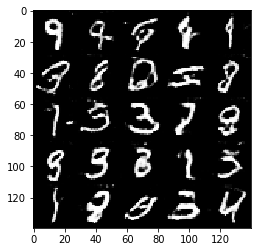

Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 1.3845
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 2.0357
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.4814
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.6697


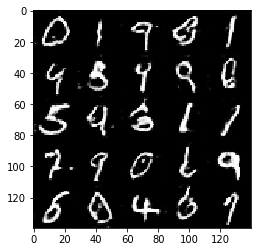

Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.5508
Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 2.2040
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.5498
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.4366
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.5215


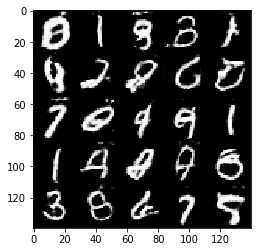

Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 3.1073
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.7684
Epoch 2/2... Discriminator Loss: 0.7243... Generator Loss: 1.6834
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 0.9799


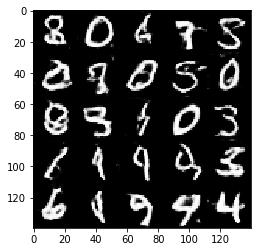

Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 2.2460
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.8405


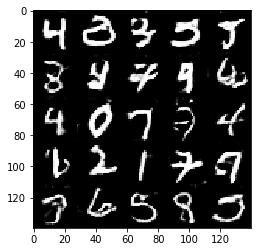

Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.3584
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.9034


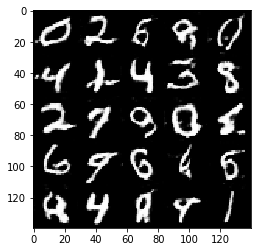

Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 2.5761
Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 1.3690


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 21.1660
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.1388
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.4476


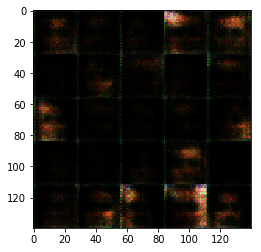

Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 3.4948
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.8749
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.1658


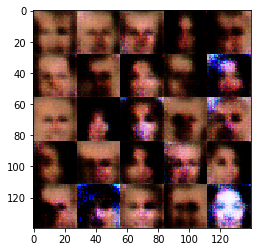

Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 2.3134... Generator Loss: 0.2327
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.9383


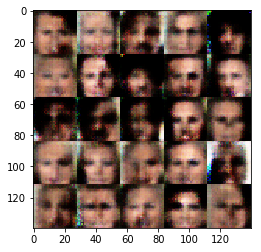

Epoch 1/1... Discriminator Loss: 2.0096... Generator Loss: 2.4197
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 2.0115... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 1.0333


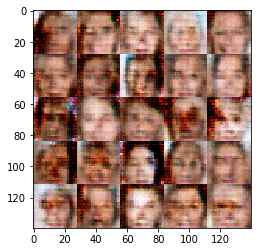

Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7281


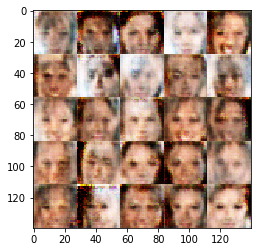

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9747


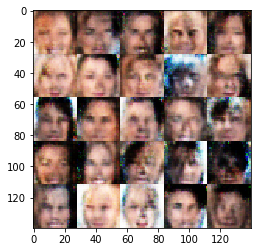

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6388


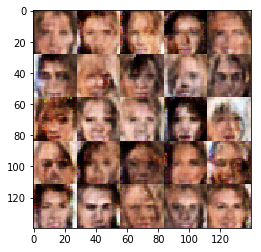

Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 1.0265


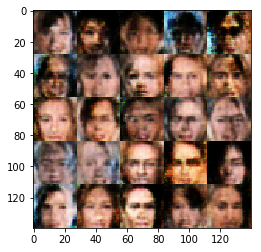

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6032


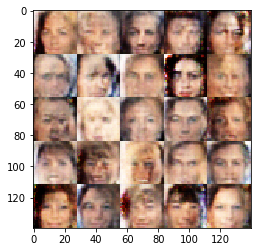

Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7122


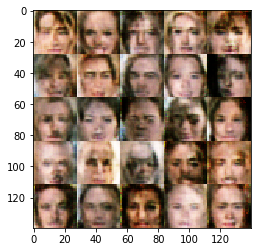

Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.2661


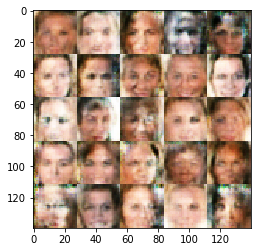

Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7272


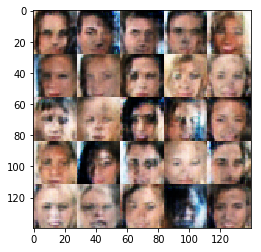

Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.8033


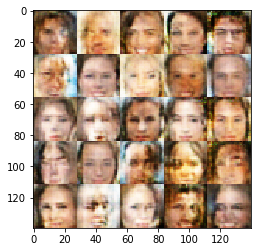

Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.4458


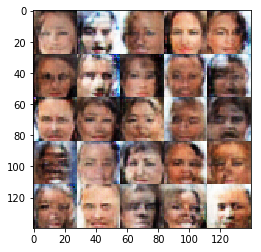

Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7434


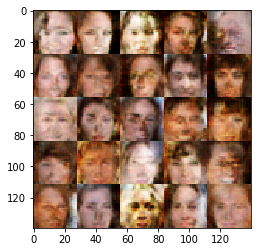

Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6775


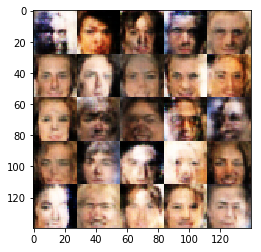

Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9952


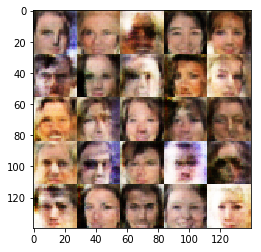

Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9770


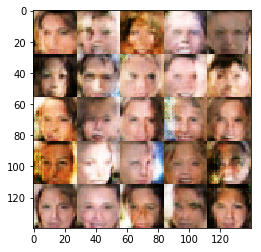

Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 1.0078


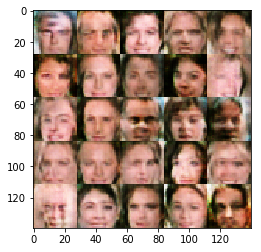

Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.8757


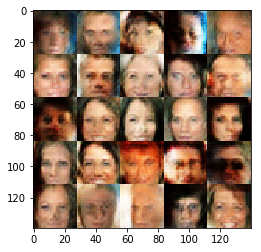

Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.8525


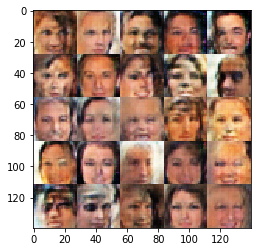

Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7415


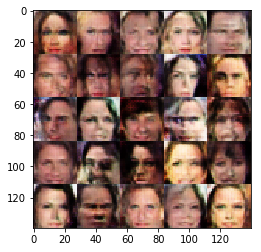

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6924


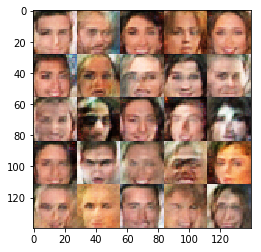

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 1.0939


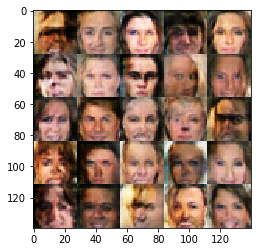

Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7857


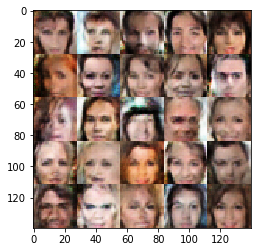

Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.8308


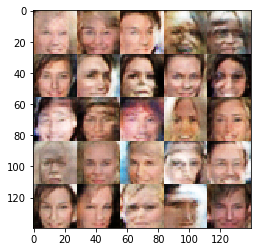

Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6723


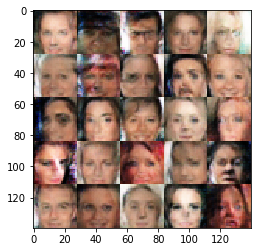

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7381


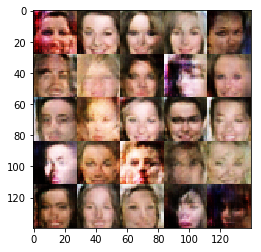

Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9968


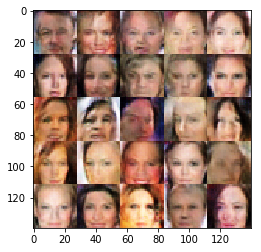

Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.0125


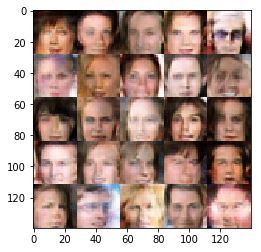

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7213


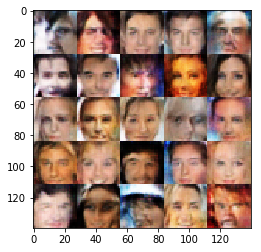

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8521


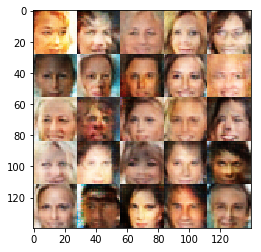

Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8761


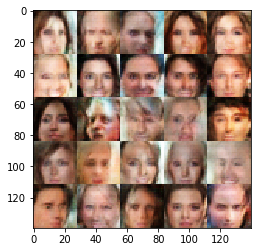

Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 1.0454


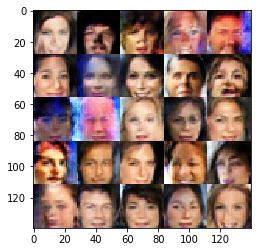

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.9182


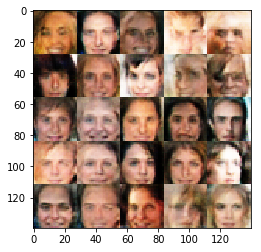

Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7727


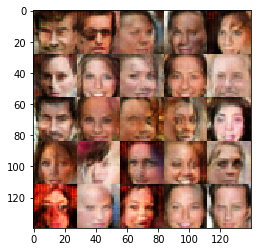

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8391


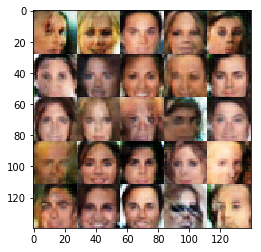

Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.8636


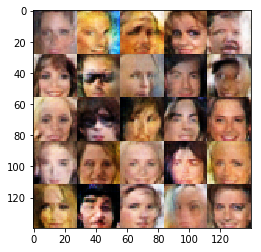

Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8464


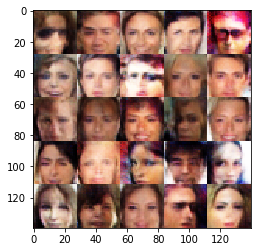

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7357


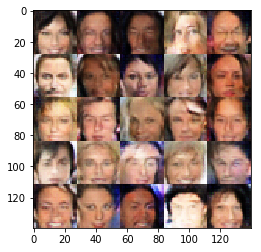

Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9644


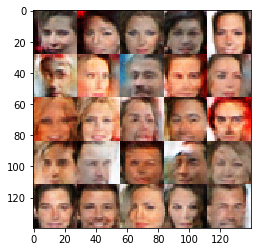

Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6766


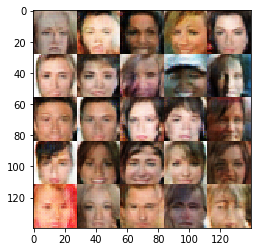

Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.8366


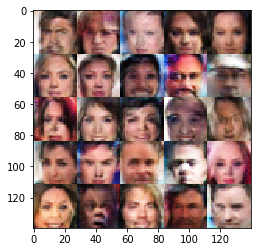

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7429


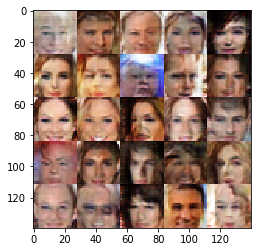

Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8112


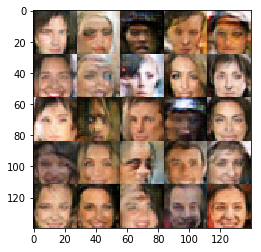

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8190


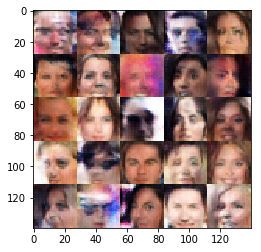

Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6318


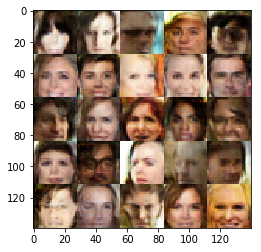

Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7932


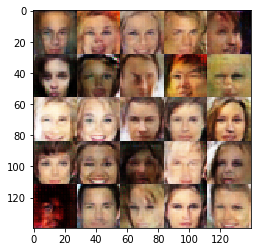

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.9797


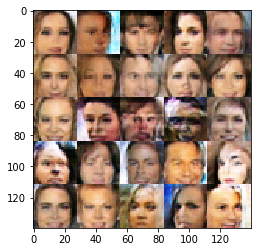

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.6814


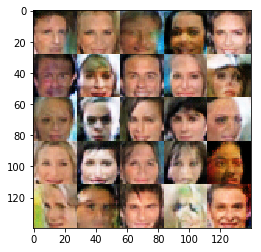

Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6087


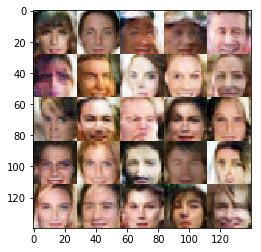

Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.6954


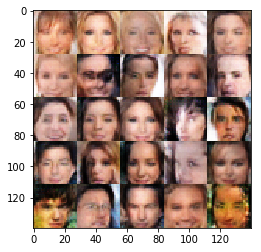

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 1.0456


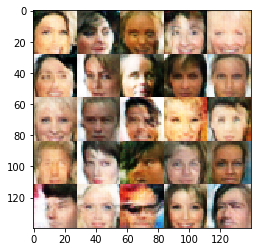

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7744


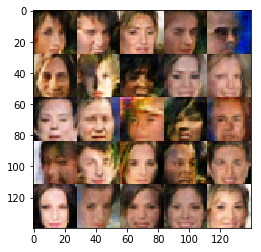

Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7394


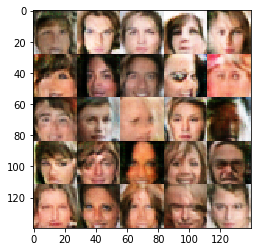

Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8074


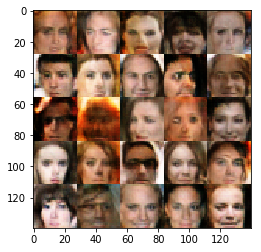

Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.5971


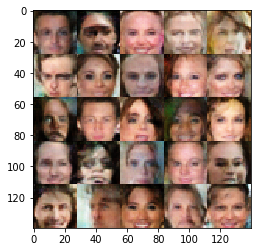

Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7324


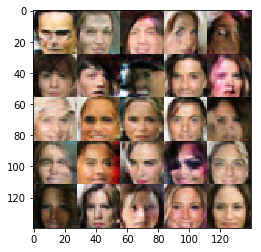

Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6755


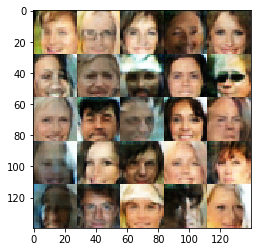

Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7574


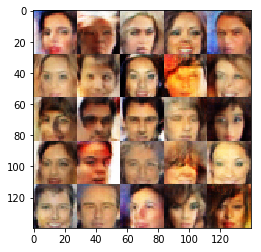

Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.9396


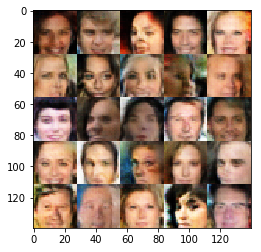

Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7876


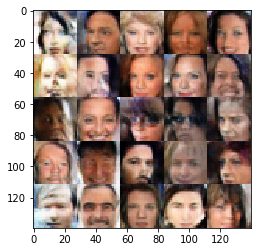

Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.9752


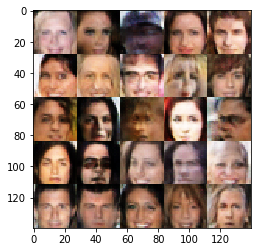

Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8274


In [22]:
batch_size = 32
z_dim = 120
learning_rate = 0.0008
beta1 = 0.5

#I followed the feedback and experimented with different hyperparameters in the provided range and edited the model. 
#This is the best combination I found. Thank you, the faces are more realistic now and the digits are clearer. 
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.